In [1]:
#LSTM + Regression on promo avg

In [1]:
folder = r"G:\Study material\Data Science\Datasets\ZS Mekktronix Sales Forecasting"
#r"/home/ws01/Documents/Datasets/Home Credit Default Risk"
seed = 22

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Basic libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import gc
import time

In [5]:
#Visualization libraries
from matplotlib.pyplot import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 12, 4

In [4]:
#modelling libraries
from sklearn.preprocessing import MinMaxScaler
#Train, test split and normalizing 
from sklearn.model_selection import train_test_split

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [6]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.precision', 3)

In [7]:
train_raw = pd.read_csv(os.path.join(folder,"yds_train2018.csv"))
train_raw.shape

(79072, 8)

In [8]:
train_raw.columns

Index(['S_No', 'Year', 'Month', 'Week', 'Merchant_ID', 'Product_ID', 'Country', 'Sales'], dtype='object')

In [9]:
id_col = 'S_No'

In [10]:
target = train_raw['Sales'] #Regression problem

In [11]:
train_year_unique = list(train_raw.Year.unique())
train_month_unique = list(train_raw.Month.unique())
train_country_unique = list(train_raw.Country.unique())
train_product_unique = list(train_raw.Product_ID.unique())

In [12]:
test_raw = pd.read_csv(os.path.join(folder,"yds_test2018.csv"))
test_raw.shape

(105, 6)

In [13]:
train_raw.set_index(id_col,inplace=True)
test_raw.set_index(id_col,inplace=True)

In [14]:
train_raw.head()

,Year,Month,Week,Merchant_ID,Product_ID,Country,Sales
S_No,,,,,,,
1,2013,1,1,ar00001,1,Argentina,157500.0
2,2013,1,1,ar00003,1,Argentina,39375.0
3,2013,1,1,ar00004,1,Argentina,15750.0
4,2013,1,1,ar00007,1,Argentina,47250.0
5,2013,1,1,ar00008,1,Argentina,283500.0


In [15]:
train = pd.DataFrame(train_raw.groupby(['Year','Month','Product_ID','Country'])['Sales'].sum())

In [16]:
test_raw.head()

,Year,Month,Product_ID,Country,Sales
S_No,,,,,
79073,2016,4,1,Argentina,NaN
79074,2016,5,1,Argentina,NaN
79075,2016,6,1,Argentina,NaN
79076,2016,7,1,Argentina,NaN
79077,2016,8,1,Argentina,NaN


In [17]:
train.reset_index(inplace=True)
train.head()

,Year,Month,Product_ID,Country,Sales
0,2013,1,1,Argentina,3.435e+07
1,2013,1,1,Columbia,3.947e+06
2,2013,1,2,Argentina,2.752e+06
3,2013,1,2,Belgium,3.149e+05
4,2013,1,2,Columbia,2.885e+06


In [18]:
counts = train.groupby(['Country','Product_ID']).count()
counts

Year  Month  Sales
Country   Product_ID                    
Argentina 1             39     39     39
          2             39     39     39
          3             24     24     24
Belgium   2             39     39     39
Columbia  1             39     39     39
          2             39     39     39
          3             28     28     28
Denmark   2             39     39     39
England   4             34     34     34
          5             34     34     34
Finland   4             34     34     34

In [19]:
counts_test = test_raw.groupby(['Country','Product_ID']).count()
counts_test

Year  Month  Sales
Country   Product_ID                    
Argentina 1             12     12      0
          2             12     12      0
          3              3      3      0
Belgium   2             12     12      0
Columbia  1             12     12      0
          2             12     12      0
          3              3      3      0
Denmark   2             12     12      0
England   4              9      9      0
          5              9      9      0
Finland   4              9      9      0

In [20]:
train_year_unique

[2013, 2014, 2015, 2016]

In [21]:
promo_raw = pd.read_csv(os.path.join(folder,"promotional_expense.csv"))

In [22]:
promo_raw[(promo_raw.Country == 'Columbia') & (promo_raw.Year == 2013)].sort_values(['Product_Type','Year']).head(5)

,Year,Month,Country,Product_Type,Expense_Price
3,2013,1,Columbia,1,1893.122
9,2013,2,Columbia,1,1977.945
15,2013,3,Columbia,1,2033.220
21,2013,4,Columbia,1,2022.229
27,2013,5,Columbia,1,2114.103


In [23]:
holidays_raw = pd.read_excel(os.path.join(folder,"holidays.xlsx"))

In [24]:
holidays_raw.head()

,Date,Country,Holiday
0,"2014, 1, 1",Denmark,Nytårsdag
1,"2014, 4, 17",Denmark,Skærtorsdag
2,"2014, 4, 18",Denmark,Langfredag
3,"2014, 4, 20",Denmark,Påskedag
4,"2014, 4, 21",Denmark,Anden påskedag


In [25]:
#['Year','Month','Product_Type','Country']
holidays_raw['Year'] = holidays_raw['Date'].apply(lambda x: int(x.split(",")[0].strip()))
holidays_raw['Month'] = holidays_raw['Date'].apply(lambda x: int(x.split(",")[1].strip()))
holidays_raw['Date'] = holidays_raw['Date'].apply(lambda x: int(x.split(",")[2].strip()))

In [26]:
holidays_raw.head()

,Date,Country,Holiday,Year,Month
0,1,Denmark,Nytårsdag,2014,1
1,17,Denmark,Skærtorsdag,2014,4
2,18,Denmark,Langfredag,2014,4
3,20,Denmark,Påskedag,2014,4
4,21,Denmark,Anden påskedag,2014,4


In [27]:
holidays_raw.Holiday = holidays_raw.Holiday.apply(lambda x: x.replace('"','').strip() if '"' in x else x.strip())

In [28]:
holidays_raw[(holidays_raw.Year == 2011) & (holidays_raw.Country == 'England') & (holidays_raw.Month == 1)].head()

,Date,Country,Holiday,Year,Month
521,1,England,New Years Day,2011,1
522,3,England,New Years Day,2011,1


In [29]:
holidays_raw[(holidays_raw.Year == 2011) & (holidays_raw.Country == 'Argentina') & (holidays_raw.Month == 4)].head()

,Date,Country,Holiday,Year,Month
312,21,Argentina,Semana Santa,2011,4
313,22,Argentina,Semana Santa,2011,4
314,24,Argentina,Día de Pascuas [Easter Day],2011,4
315,2,Argentina,Día del Veterano y de los Caidos en la Guerra de Malvinas [Veterans Dayand the Fallen in the Malvinas War],2011,4


In [30]:
holidays = pd.DataFrame(holidays_raw.groupby(['Year','Month','Country'])['Holiday'].apply(list)) #.apply(lambda x: ','.join(x)))

In [31]:
holidays.head()

Holiday
Year Month Country                                       
2011 1     Argentina          [Año Nuevo [New Years Day]]
           Belgium                        [Nieuwjaarsdag]
           Columbia   [Día de los Reyes Magos [Epiphany]]
           Denmark                            [Nytårsdag]
           England         [New Years Day, New Years Day]

In [32]:
holidays.loc[(2011,1,'England')]

Holiday    [New Years Day, New Years Day]
Name: (2011, 1, England), dtype: object

In [33]:
holidays['num'] = holidays['Holiday'].apply(lambda x: len(x))

In [34]:
holidays.num.unique()

array([1, 2, 3, 4], dtype=int64)

In [35]:
holidays[holidays.num == 3].sample(5)

Holiday  num
Year Month Country                                                                                                                 
2011 6     Belgium                                                            [O.L.H. Hemelvaart, Pinksteren, Pinkstermaandag]    3
2016 5     Columbia  [Día del Trabajo [Labour Day], Ascensión del señor [Ascension of Jesus], Corpus Christi [Corpus Christi]]    3
2012 4     Finland                                                           [Pitkäperjantai, Pääsiäispäivä, 2. pääsiäispäivä]    3
2018 4     Denmark                                                                   [Påskedag, Anden påskedag, Store bededag]    3
     3     Columbia         [Día de San José [Saint Josephs Day], Jueves Santo [Maundy Thursday], Viernes Santo [Good Friday]]    3

In [36]:
holidays[holidays.num == 4].sample(5)

Holiday  num
Year Month Country                                                                                                                                                                              
2011 4     Argentina  [Semana Santa, Semana Santa, Día de Pascuas [Easter Day], Día del Veterano y de los Caidos en la Guerra de Malvinas [Veterans Dayand the Fallen in the Malvinas War]]    4
           Denmark                                                                                                                      [Skærtorsdag, Langfredag, Påskedag, Anden påskedag]    4
2013 5     Belgium                                                                                                      [O.L.H. Hemelvaart, Pinksteren, Pinkstermaandag, Dag van de Arbeid]    4
2012 5     Belgium                                                                                                      [O.L.H. Hemelvaart, Pinksteren, Pinkstermaandag, Dag van de Arbeid]    4
2018 12    Finland                                                                                                                [Itsenäisyyspäivä, Joulupäivä, Tapaninpäivä, Jouluaatto}]    4

In [37]:
holidays.reset_index(inplace=True)

In [38]:
holidays.head()

,Year,Month,Country,Holiday,num
0,2011,1,Argentina,[Año Nuevo [New Years Day]],1
1,2011,1,Belgium,[Nieuwjaarsdag],1
2,2011,1,Columbia,[Día de los Reyes Magos [Epiphany]],1
3,2011,1,Denmark,[Nytårsdag],1
4,2011,1,England,"[New Years Day, New Years Day]",2


In [39]:
#merge promo with train
train = pd.merge(train,promo_raw,how='left', left_on=['Year','Month','Product_ID','Country'],
                 right_on = ['Year','Month','Product_Type','Country'])

In [40]:
test = pd.merge(test_raw,promo_raw,how='left', left_on=['Year','Month','Product_ID','Country'],
                 right_on = ['Year','Month','Product_Type','Country'])

In [41]:
train = pd.merge(train,holidays,how='left', left_on=['Year','Month','Country'],
                 right_on = ['Year','Month','Country'])

In [42]:
test = pd.merge(test,holidays,how='left', left_on=['Year','Month','Country'],
                 right_on = ['Year','Month','Country'])

In [43]:
train.head(10)

,Year,Month,Product_ID,Country,Sales,Product_Type,Expense_Price,Holiday,num
0,2013,1,1,Argentina,3.435e+07,1.0,14749.307,[Año Nuevo [New Years Day]],1.0
1,2013,1,1,Columbia,3.947e+06,1.0,1893.122,"[Año Nuevo [New Years Day], Día de los Reyes Magos [Epiphany]]",2.0
2,2013,1,2,Argentina,2.752e+06,2.0,1329.374,[Año Nuevo [New Years Day]],1.0
3,2013,1,2,Belgium,3.149e+05,2.0,249.590,[Nieuwjaarsdag],1.0
4,2013,1,2,Columbia,2.885e+06,2.0,1436.726,"[Año Nuevo [New Years Day], Día de los Reyes Magos [Epiphany]]",2.0
5,2013,1,2,Denmark,1.018e+08,2.0,43843.906,[Nytårsdag],1.0
6,2013,1,4,England,1.669e+05,4.0,183.482,[New Years Day],1.0
7,2013,1,4,Finland,1.515e+07,4.0,750.618,"[Uudenvuodenpäivä, Loppiainen]",2.0
8,2013,1,5,England,4.624e+05,5.0,330.367,[New Years Day],1.0
9,2013,2,1,Argentina,3.201e+07,1.0,12187.566,"[Día de Carnaval [Carnivals Day], Día de Carnaval [Carnivals Day]]",2.0


In [44]:
train.Expense_Price.fillna(0,inplace=True)
train.num.fillna(0,inplace=True)
train.Holiday.fillna('No',inplace=True)
if 'Product_Type' in train.columns:
    train.drop('Product_Type',axis=1,inplace=True)

In [45]:
test.Expense_Price.fillna(0,inplace=True)
test.num.fillna(0,inplace=True)
test.Holiday.fillna('No',inplace=True)
if 'Product_Type' in test.columns:
    test.drop('Product_Type',axis=1,inplace=True)

In [46]:
test.head()

,Year,Month,Product_ID,Country,Sales,Expense_Price,Holiday,num
0,2016,4,1,Argentina,NaN,8214.875,[Día del Veterano y de los Caidos en la Guerra de Malvinas [Veterans Dayand the Fallen in the Malvinas War]],1.0
1,2016,5,1,Argentina,NaN,10777.878,"[Día del Trabajo [Labour Day], Día de la Revolucion de Mayo [May Revolution Day]]",2.0
2,2016,6,1,Argentina,NaN,10320.673,"[Día Pase a la Inmortalidad del General Martín Miguel de Güemes [Day Pass to the Immortality of General Martín Miguel de Güemes], Día Pase a la Inmortalidad del General D. Manuel Belgrano [Day Pas...",2.0
3,2016,7,1,Argentina,NaN,7377.587,[Día de la Independencia [Independence Day]],1.0
4,2016,8,1,Argentina,NaN,9805.705,[Día Pase a la Inmortalidad del General D. José de San Martin [Day Pass to the Immortality of General D. José de San Martin]],1.0


In [47]:
train.Year = train.Year.astype(str)
train.Month = train.Month.astype(str)
train['Date'] = train['Year'] + "-" + train['Month']

In [48]:
test.Year = test.Year.astype(str)
test.Month = test.Month.astype(str)
test['Date'] = test['Year'] + "-" + test['Month']

In [49]:
import datetime

In [50]:
train['Date'] = train['Date'].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m"))

In [51]:
test['Date'] = test['Date'].apply(lambda x: datetime.datetime.strptime(x,"%Y-%m"))

In [52]:
train.sample(5)

,Year,Month,Product_ID,Country,Sales,Expense_Price,Holiday,num,Date
76,2013,9,2,Columbia,3.655e+06,1791.906,No,0.0,2013-09-01
98,2013,11,5,England,5.786e+05,386.902,No,0.0,2013-11-01
36,2013,5,1,Argentina,3.879e+07,15652.861,"[Día del Trabajo [Labour Day], Día de la Revolucion de Mayo [May Revolution Day]]",2.0,2013-05-01
54,2013,7,1,Argentina,3.713e+07,14144.888,[Día de la Independencia [Independence Day]],1.0,2013-07-01
273,2015,5,4,Finland,2.445e+07,1148.367,"[Vappu, Helatorstai, Helluntaipäivä]",3.0,2015-05-01


In [167]:
counts_test

Year  Month  Sales
Country   Product_ID                    
Argentina 1             12     12      0
          2             12     12      0
          3              3      3      0
Belgium   2             12     12      0
Columbia  1             12     12      0
          2             12     12      0
          3              3      3      0
Denmark   2             12     12      0
England   4              9      9      0
          5              9      9      0
Finland   4              9      9      0

In [111]:
counts

Year  Month  Sales
Country   Product_ID                    
Argentina 1             39     39     39
          2             39     39     39
          3             24     24     24
Belgium   2             39     39     39
Columbia  1             39     39     39
          2             39     39     39
          3             28     28     28
Denmark   2             39     39     39
England   4             34     34     34
          5             34     34     34
Finland   4             34     34     34

In [440]:
#Sequence generation taken from 
#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/ 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [467]:
def predict(working,working_test,past_vals = 2,result="No"):
    from numpy.random import seed
    seed(21)
    from tensorflow import set_random_seed
    set_random_seed(21)
    ts = working['Sales']
    ts_train_size = int(len(ts) * 0.50)
    ts_train, ts_test = ts[0:ts_train_size], ts[ts_train_size:]
    # walk-forward validation
    history = [x for x in ts_train]
    predictions = list()
    for i in range(len(ts_test)):
        # predict
        yhat = history[-1]
        predictions.append(yhat)
        # observation
        obs = ts_test[i]
        history.append(obs)
        #print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
    # report performance
    mse = mean_squared_error(ts_test, predictions)
    rmse = sqrt(mse)
    print('RMSE: %.3f' % rmse)
    
    dataset = working[['Sales','Expense_Price']]
    # load dataset
    values = dataset.values

    # ensure all data is float
    values = values.astype('float32')

    # normalize features
    scaler = MinMaxScaler() #feature_range=(0, 1)
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(scaled, past_vals, 1)
    scale = pd.DataFrame()
    Sales_max = dataset['Sales'].max(axis=0)
    Sales_min = dataset['Sales'].min(axis=0)
    Expense_Price_max = dataset['Expense_Price'].max(axis=0)
    Expense_Price_min = dataset['Expense_Price'].min(axis=0)
    cols_2_drop = [(reframed.shape[1] - i-1) for i in range(dataset.shape[1]-1)]
    # drop columns we don't want to predict
    reframed.drop(reframed.columns[cols_2_drop], axis=1, inplace=True)
    #print(reframed.head()) #Var1: Sales Var2: Expenses
    # split into train and test sets
    values = reframed.values
    n_train_hours = int(reframed.shape[0]*0.75)
    train_lstm = values[:n_train_hours, :]
    test_lstm = values[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train_lstm[:, :-1], train_lstm[:, -1]
    test_X, test_y = test_lstm[:, :-1], test_lstm[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    #print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=150,validation_data=(test_X, test_y), verbose=0, shuffle=False) #batch_size=72, 
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:,-1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:,-1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
    if result == "Yes":
        #predict for test
        working_test.set_index('Date',inplace=True)
        exp_test = working_test['Expense_Price']
        exp_test = pd.DataFrame(exp_test.reshape((len(exp_test), 1)),columns=['Expense_Price'])
        exp_test = (exp_test - Expense_Price_min)/(Expense_Price_max - Expense_Price_min)
        inputs = test_X[-1].reshape((1,1,2*past_vals))
        for i in range(exp_test.shape[0]):
            yhat = model.predict(inputs)
            output = yhat[0][0]*(Sales_max - Sales_min) + Sales_min
            working_test['Sales'][i] = output
            old_inputs = inputs.reshape(2*past_vals)
            new_inputs = []
            for j in range(2,2*past_vals):
                new_inputs.append(old_inputs[j])
            new_inputs.append(yhat[0][0])
            new_inputs.append(exp_test.loc[i,'Expense_Price'])
            inputs = np.array(new_inputs).reshape((1,1,2*past_vals))
        return working_test

In [375]:
#working.Sales = working.Sales/max(working.Sales)
#working.Expense_Price = working.Expense_Price/max(working.Expense_Price)
#working.num = working.num/max(working.num)
'''
plt.plot(working.Date,working.Sales)
plt.plot(working.Date,working.Expense_Price)
plt.plot(working.Date,working.num)
plt.legend(loc='right')
plt.show()
'''

In [657]:
product = 4
country = 'Finland'

RMSE: 13426298.706


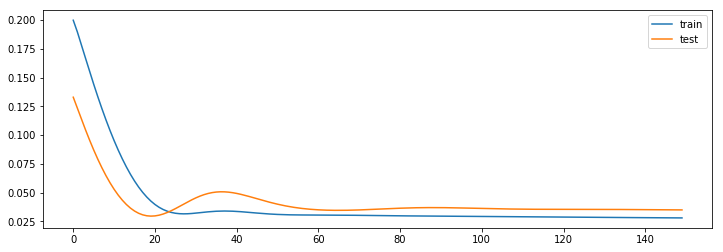

Test RMSE: 7685777.829


In [658]:
working = train[(train.Country == country) & (train.Product_ID == product)]
working_test = test[(test.Country == country) & (test.Product_ID == product)]
working.set_index('Date',inplace=True)
days = 5
working_test = predict(working,working_test,days,"Yes")

In [659]:
working_test

,Year,Month,Product_ID,Country,Sales,Expense_Price,Holiday,num
Date,,,,,,,,
2015-11-01,2015,11,4,Finland,2.953e+07,1306.731,No,0.0
2015-12-01,2015,12,4,Finland,3.188e+07,1499.447,"[Itsenäisyyspäivä, Joulupäivä, Tapaninpäivä, Jouluaatto]",4.0
2016-01-01,2016,1,4,Finland,3.061e+07,1181.306,"[Uudenvuodenpäivä, Loppiainen]",2.0
2016-02-01,2016,2,4,Finland,3.107e+07,940.191,No,0.0
2016-03-01,2016,3,4,Finland,2.944e+07,1439.734,"[Pitkäperjantai, Pääsiäispäivä, 2. pääsiäispäivä]",3.0
2016-04-01,2016,4,4,Finland,2.998e+07,1378.859,No,0.0
2016-05-01,2016,5,4,Finland,3.221e+07,970.194,"[Vappu, Helatorstai, Helluntaipäivä]",3.0
2016-06-01,2016,6,4,Finland,2.802e+07,1289.024,"[Juhannuspäivä, Juhannusaatto]",2.0
2016-07-01,2016,7,4,Finland,2.671e+07,900.083,No,0.0


In [631]:
#working_test.Sales[2] = working_test.Sales[0]

In [660]:
working_test.reset_index(inplace=True)

In [661]:
days.append(past_days)

In [664]:
days

[2, 4, 4, 5, 1, 4, 3, 3, 2, 3, 5]

In [662]:
if ((product == 1) & (country == 'Argentina')):
    final_test = pd.DataFrame()
final_test = final_test.append(working_test)

In [663]:
final_test.tail()

,Date,Year,Month,Product_ID,Country,Sales,Expense_Price,Holiday,num
4,2016-03-01,2016,3,4,Finland,2.944e+07,1439.734,"[Pitkäperjantai, Pääsiäispäivä, 2. pääsiäispäivä]",3.0
5,2016-04-01,2016,4,4,Finland,2.998e+07,1378.859,No,0.0
6,2016-05-01,2016,5,4,Finland,3.221e+07,970.194,"[Vappu, Helatorstai, Helluntaipäivä]",3.0
7,2016-06-01,2016,6,4,Finland,2.802e+07,1289.024,"[Juhannuspäivä, Juhannusaatto]",2.0
8,2016-07-01,2016,7,4,Finland,2.671e+07,900.083,No,0.0


In [670]:
final_test.reset_index(inplace=True)
final_test.drop('index',axis=1,inplace=True)
final_test.reset_index(inplace=True)

In [665]:
final_test.shape

(105, 9)

In [666]:
#test_raw = pd.read_csv(os.path.join(folder,"yds_test2018.csv"))

In [667]:
#sub = pd.DataFrame()

In [671]:
sub = final_test[['index','Year','Month','Product_ID','Country','Sales']]

In [672]:
sub.to_csv(os.path.join(folder,"submission2.csv"),index = False)

In [673]:
sub.head()

,index,Year,Month,Product_ID,Country,Sales
0,0,2016,4,1,Argentina,2.114e+07
1,1,2016,5,1,Argentina,2.085e+07
2,2,2016,6,1,Argentina,2.410e+07
3,3,2016,7,1,Argentina,2.674e+07
4,4,2016,8,1,Argentina,2.587e+07


In [ ]:
'''
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
'''